<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/RTM_Machine_Learning_vs_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview of the steps:

1) Generate prosail hyperspectral data with 5 varying traits, one observation angle and one sun position. 

2) Convert them to Sentinel 2A (or B, or a mixture of both) spectral resolution

3) Train Machine learning (ANN, RF and GPR) and test 

4) Test optimization algorithms: Grad desc; Swarm and an evolutionary algorithm 

5) Generate plots and save 


In [3]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

#this is the swarm optimization package
!pip install --upgrade pyswarm

#spotpy
!pip install spotpy

#bayesian optimization packages
!pip install bayesian-optimization

Requirement already up-to-date: pyswarm in /usr/local/lib/python3.6/dist-packages (0.6)


In [0]:
#importing packages

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model



Step 1: Generating data \\

First we define a function that converts the input hyperspectral data into Sentinel 2 A (or B) data. The Spectral Response Function for this can be obtained from ESA at: [ESA Sentinel 2 SRF](https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses). \\

Once this is downloaded, one of the sheets has the SRF of S2A and the other S2B and by copying this to a new CSV file, as is, then we have the necessary file for running this section. An image example of how the csv should look like can be seen in [link](https://www.dropbox.com/s/sb25k5ikt3q0bfx/CSV%20example.png?dl=0) \\

The method for generating S2 responses is the Weighted arithmetic mean (check [wikipedia](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)): [Formula](https://www.dropbox.com/s/a3ye7ch2puatv5q/WeightedMean.png?dl=0) \\







First we define a function that takes as input a path to the CSV described above and an hyperpectral spectra (numpy array) as generated by PROSAIL

In [0]:
def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/content/S2_Response.csv"

Now we generate the trait space: 
1.  3000 samples which will be used for training the various machine learning 
2.  1000 samples which will be sidelined and used for validation



In [0]:
#number of samples
train_n = 3000
valid_n = 1000
n_traits=5 #I will test on 5 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
LHS_train = lhsmdu.createRandomStandardUniformMatrix(n_traits,train_n ) #the package has a more advanced method but it is too slow to process
LHS_valid = lhsmdu.createRandomStandardUniformMatrix(n_traits,valid_n ) 

#Here we set the max values of the traits. These are to be multiplied by an array between [0,1],
#thus there is a risk of very low values of the traits causing erroneous ouput from prosail. 

#max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=79. #add 1
max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.008 #add 0.001 
max_cm=0.008 #0.001
max_lai = 9.9 #add 0.1


#in here I create a custom call for prosail, this allows me to more easily control the default values
def custom_prosail(cab,car,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.2
  cbrown=0.01
  typelidf=1
  lidfa = -0.35 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,hspot,tts,tto,psi,
                                 typelidf, #lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
  return(rho_out)

pd_train_traits = pd.DataFrame.transpose(pd.DataFrame(LHS_train))
pd_train_traits.columns = ["cab","car","cw","cm","lai"]
pd_valid_traits = pd.DataFrame.transpose(pd.DataFrame(LHS_valid))
pd_valid_traits.columns = ["cab","car","cw","cm","lai"]

#this addition is to avoid extreme values that can perhaps cause prosail failure
pd_train_traits["car"]=pd_train_traits["car"]*max_car+1 
pd_train_traits["cab"]=pd_train_traits["cab"]*max_cab+1
pd_train_traits["cw"] =pd_train_traits["cw"]*max_cw+.001
pd_train_traits["cm"] =pd_train_traits["cm"]*max_cm+.001
pd_train_traits["lai"]=pd_train_traits["lai"]*max_lai+.25
#pd_train_traits["n"]=pd_train_traits["n"]*max_n+1
#pd_train_traits["car"]=pd_train_traits["cab"]*max_car+1 #changed here to cab to ensure that it is 100% autocorrelated 
#pd_train_traits["cbrown"]=pd_train_traits["cbrown"]*max_cbrown+ 0.01

pd_valid_traits["car"]=pd_valid_traits["car"]*max_car+1 
pd_valid_traits["cab"]=pd_valid_traits["cab"]*max_cab+1
pd_valid_traits["cw"]=pd_valid_traits["cw"]*max_cw+.001
pd_valid_traits["cm"]=pd_valid_traits["cm"]*max_cm+.001
pd_valid_traits["lai"]=pd_valid_traits["lai"]*max_lai+.25
#pd_valid_traits["n"]=pd_valid_traits["n"]*max_n+1
#pd_valid_traits["car"]=pd_valid_traits["cab"]*max_car+1 #changed here to cab to ensure that it is 100% autocorrelated
#pd_valid_traits["cbrown"]=pd_valid_traits["cbrown"]*max_cbrown+ 0.01


Now we can finally loop to generate the PROSAIL output, first in hyperspectral and then in sentinel radiometric resolution

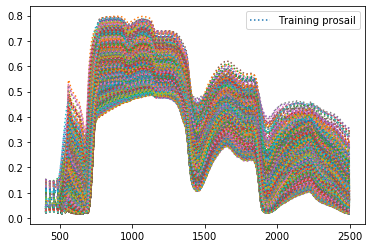

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


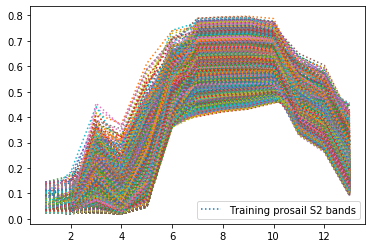

training dataset s2 shape
(3000, 13)


In [7]:
#THIS SECTION GENERATES THE TRAINING DATA

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_train_traits)):
    #print(i)

    #n_t = pd_train_traits["n"][i]
    cab_t = pd_train_traits["cab"][i]
    car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = pd_train_traits["cw"][i]
    cm_t = pd_train_traits["cm"][i]
    lai_t = pd_train_traits["lai"][i]


    if k == 1:
      tr_rho_s = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      plt.plot ( x, tr_rho_t, ':')

    
    k = k+1

plt.show()


#now, we convert the above for sentinel 2 A resolution
#aux for x axis
x_s2 = np.arange(1,14)
print(x_s2)

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_train_traits)):
    #print(i)

    #n_t = pd_train_traits["n"][i]
    cab_t = pd_train_traits["cab"][i]
    car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = pd_train_traits["cw"][i]
    cm_t = pd_train_traits["cm"][i]
    lai_t = pd_train_traits["lai"][i]

    if k == 1:
      tr_rho_s_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_s_s2 = Prosail2S2(filepath,tr_rho_s_s2)

      plt.plot ( x_s2, tr_rho_s_s2, ':', label="Training prosail S2 bands")
      plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_t_s2 = Prosail2S2(filepath,tr_rho_t_s2)

      tr_rho_s_s2 = np.vstack((tr_rho_s_s2,tr_rho_t_s2))
      plt.plot ( x_s2, tr_rho_t_s2, ':')

    
    k = k+1

plt.show()
#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12
print("training dataset s2 shape")
print(tr_rho_s_s2.shape)


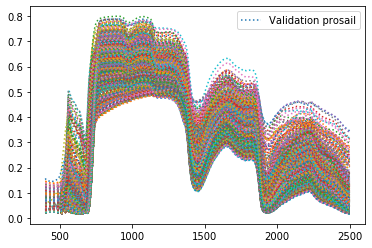

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


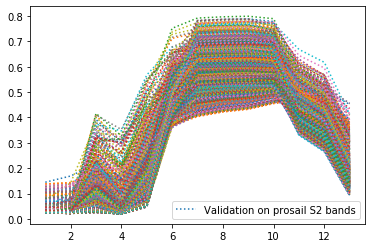

training dataset s2 shape
(1000, 13)


In [8]:
#now we do the same for the validation dataset

#THIS SECTION GENERATES THE VALIDATION DATA

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_valid_traits)):
    #print(i)

    #n_t = pd_valid_traits["n"][i]
    cab_t = pd_valid_traits["cab"][i]
    car_t = pd_valid_traits["car"][i]
    #cbrown_t = pd_valid_traits["cbrown"][i]
    cw_t = pd_valid_traits["cw"][i]
    cm_t = pd_valid_traits["cm"][i]
    lai_t = pd_valid_traits["lai"][i]


    if k == 1:
      vl_rho_s = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      plt.plot ( x, vl_rho_s, ':', label="Validation prosail")
      plt.legend(loc='best')
      
    if k > 1:
      vl_rho_t = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_s = np.vstack((vl_rho_s,vl_rho_t))
      plt.plot ( x, vl_rho_t, ':')

    
    k = k+1

plt.show()


#now, we convert the above for sentinel 2 A resolution
#aux for x axis
x_s2 = np.arange(1,14)
print(x_s2)

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_valid_traits)):
    #print(i)

    #n_t = pd_valid_traits["n"][i]
    cab_t = pd_valid_traits["cab"][i]
    car_t = pd_valid_traits["car"][i]
    #cbrown_t = pd_valid_traits["cbrown"][i]
    cw_t = pd_valid_traits["cw"][i]
    cm_t = pd_valid_traits["cm"][i]
    lai_t = pd_valid_traits["lai"][i]

    if k == 1:
      vl_rho_s_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_s_s2 = Prosail2S2(filepath,vl_rho_s_s2)

      plt.plot ( x_s2, vl_rho_s_s2, ':', label="Validation on prosail S2 bands")
      plt.legend(loc='best')
      
    if k > 1:
      vl_rho_t_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_t_s2 = Prosail2S2(filepath,vl_rho_t_s2)

      vl_rho_s_s2 = np.vstack((vl_rho_s_s2,vl_rho_t_s2))
      plt.plot ( x_s2, vl_rho_t_s2, ':')

    
    k = k+1

plt.show()

#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12
print("training dataset s2 shape")
print(vl_rho_s_s2.shape)



Now all that is left is removing the unused bands

In [0]:
#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12

#we pick only the bands at 20m resolution - i reckon it is actually peaceful to use everything.. 
s2_train_df = tr_rho_s_s2[:,[1,2,3,4,5,6,8,11,12]]
s2_valid_df = vl_rho_s_s2[:,[1,2,3,4,5,6,8,11,12]]

Now that we have generated a training and validation dataset lets do the machine learning part. 


First we train a ANN (with the same structure as i did for ESA OPEN SCIENCE), then a Random Forest and finally a GPR. 


For now, i will just test against the validation data - no kfolding. 

Training the Artificial neural network:

package: sklearn
link to function: [ANN](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

Links of interest: \\
[keras layers core](https://keras.io/layers/core/) \\
[keras loss functions](https://keras.io/losses/) \\
[keras optimizers](https://keras.io/optimizers/) \\
[example](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) \\

In [10]:
#machine learning stuff
from sklearn.neural_network import MLPRegressor as ANN_reg #this is a simpler neural network package

from keras.models import Sequential
from keras.layers import Dense
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#ignore the warning for now

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
#creating the ANN and fitting
ann_ml = Sequential()
#ann_ml.add(Dense(9, input_dim=9, activation='linear'))
ann_ml.add(Dense(10, input_dim=9, activation='tanh'))
ann_ml.add(Dense(6, activation='tanh'))
ann_ml.add(Dense(5, activation='relu')) #indeed this ha to be added in this case without any activ function, the R script added this on its own
#model.add(Dense(1, activation='sigmoid'))

# compile the keras model
ann_ml.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


#type(pd_train_traits.iloc[:,:].values)
#type(s2_train_df)
#pd_train_traits.iloc[:,:].values.shape
from sklearn.preprocessing import MinMaxScaler #this is to standardize the input data [not used for now]

#preparing data for ANN
X_ann = s2_train_df
Y_ann = pd_train_traits.iloc[:,:].values #converts from a panda table to a numpy

scaler = MinMaxScaler()#lets rescale the input
scaler.fit(Y_ann)
Y_ann_norm = scaler.transform(Y_ann)

ann_ml.fit(X_ann,Y_ann_norm,epochs=1500,verbose=0) #this hides the output spam


In [0]:
#we can now store the outputs of the neural network
Y_ann_pred = pd.DataFrame(scaler.inverse_transform(ann_ml.predict(s2_valid_df)))
Y_ann_pred.columns = ["cab","car","cw","cm","lai"]
#Y_ann_pred

Now we train the random forest

[scikit randf](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)



In [13]:
#setting up variables
X_rf=s2_train_df
Y_rf=pd_train_traits.iloc[:,:].values

# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 

rf_ml = RandomForestRegressor(n_estimators=100,random_state=0,
                              min_samples_leaf=5,min_samples_split=10,verbose=1)

rf_ml.fit(X_rf,Y_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=1, warm_start=False)

In [14]:
#we can now store the outputs of the random forest
Y_rf_pred = pd.DataFrame(rf_ml.predict(s2_valid_df))
Y_rf_pred.columns = ["cab","car","cw","cm","lai"]
#Y_rf_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Now we go for the gaussian processes regression




In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

#initializing the model
gpr_ml = GaussianProcessRegressor(n_restarts_optimizer=50,
                                        #normalize_y=True,
                                        random_state=0)
#no reason to create the variables again
gpr_ml.fit(X_rf,Y_rf)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=50, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [0]:
#we can now store the outputs of the gaussian processes regression
Y_gpr_pred = pd.DataFrame(gpr_ml.predict(s2_valid_df))
Y_gpr_pred.columns = ["cab","car","cw","cm","lai"]
#Y_rf_pred


Let's look at how the each model predicts the validation data that i left on the side


[helper link](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

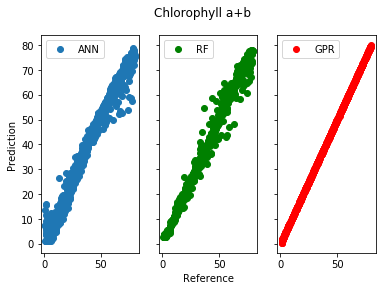

In [61]:
#plotting cab
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Chlorophyll a+b')
#fig.subplots_adjust(wspace=.3)


#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cab"],Y_ann_pred["cab"],"o",label="ANN")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cab"],Y_rf_pred["cab"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(pd_valid_traits["cab"],Y_gpr_pred["cab"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")


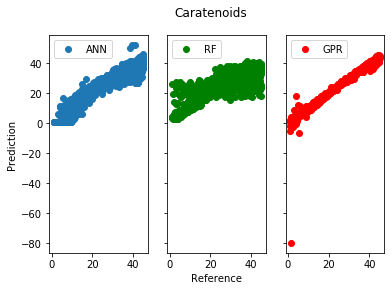

In [60]:
#plotting car
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Caratenoids')
#fig.subplots_adjust(wspace=.5)

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["car"],Y_ann_pred["car"],"o",label="ANN")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["car"],Y_rf_pred["car"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(pd_valid_traits["car"],Y_gpr_pred["car"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")



The GPR failed quite a lot on Car, lets investigate

There are multiple points below 0


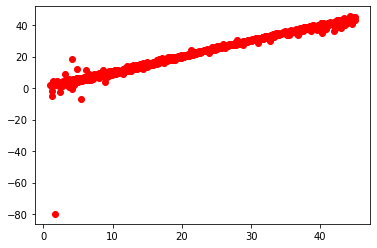

In [53]:
plt.plot(pd_valid_traits["car"],Y_gpr_pred["car"],"o",color="red",label="GPR")

print("There are multiple points below 0")

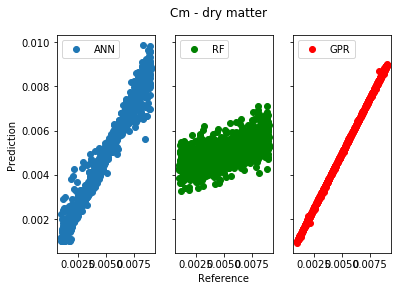

In [58]:
#plotting cm
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Cm - dry matter')
#fig.subplots_adjust(wspace=.6)

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cm"],Y_ann_pred["cm"],"o",label="ANN")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cm"],Y_rf_pred["cm"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(pd_valid_traits["cm"],Y_gpr_pred["cm"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")

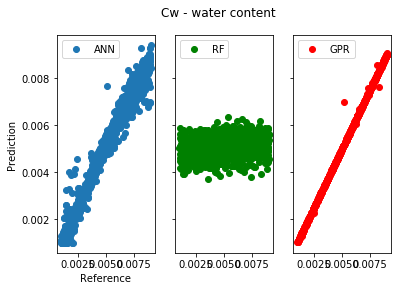

In [64]:
#plotting cm
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Cw - water content')
#fig.subplots_adjust(wspace=.6)

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cw"],Y_ann_pred["cw"],"o",label="ANN")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cw"],Y_rf_pred["cw"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[0].set_xlabel("Reference")
axs[2].plot(pd_valid_traits["cw"],Y_gpr_pred["cw"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")

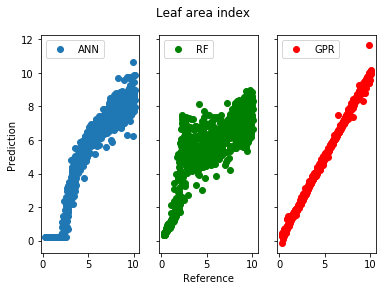

In [66]:
#plotting cm
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Leaf area index')


#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["lai"],Y_ann_pred["lai"],"o",label="ANN")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["lai"],Y_rf_pred["lai"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(pd_valid_traits["lai"],Y_gpr_pred["lai"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")

# Optimization/minimization

The key first step here is to create a minimization function. This is very plastic, it is even possible to have a minimization function that is a combination of multiple. 



In [22]:
#defining the cost function:

#Leon made this function
#this function solves given a set of traits and a prosail hyperspectral numpy array
#it has to be edited to deal with the default values - notice it is using prospect also
#def cost_spectra_hyper(x, rho):
#    n,cab,car,cbrown,cw,cm  = x
#    sim_canopy          = prosail.run_prospect(n,cab,car,cbrown,cw,cm,ant=8.0)
#    sim_canopy          = sim_canopy[1]
#    wavel               = np.array(range(400,2501,1))
#    rho_canopy1         = np.array([np.transpose(wavel), rho])
#    sim_canopy1         = np.array([np.transpose(wavel), sim_canopy])
#    samerror            = sptool.distance.SAM(rho,sim_canopy) 
#    samerror            = sptool.distance.SID(rho,sim_canopy)
#    samerror            = sptool.distance.chebyshev(rho,sim_canopy)
#    samerror            = sptool.distance.SAM(rho,sim_canopy) + (sptool.distance.SID(rho,sim_canopy)/2) + (sptool.distance.chebyshev(rho,sim_canopy)/2)
#    samerror            = sptool.distance.SAM(rho[0:1000],sim_canopy[0:1000])# + (sptool.distance.SAM(rho[1000:2101],sim_canopy[1000:2101])*10)
#    return samerror

#the next function expects an x - set of traits and a rho_s2 - a target spectra converted to sentinel 2
#and considering my current target of 20m by 20m, the rho_s2 should also use only the 20m bands
def cost_spectra_sentinel(x, rho_s2):
  import pysptools as sptool
  
  #cost function can be easily editable here, all it is needed is to add
  #interactions between the various spectral differences methods on the return
  cab,car,cw,cm,lai  = x
  sim_canopy = custom_prosail(cab,car,cw,cm,lai)
  sim_canopy = Prosail2S2(filepath,sim_canopy)
    #print(sim_canopy)
    #print(sim_canopy.shape)
    #print(sim_canopy[[1,2,3,4,5,6,8,11,12],])
  sim_canopy = sim_canopy[[1,2,3,4,5,6,8,11,12],]

#    wavel               = np.array(range(400,2501,1))
#    rho_canopy1         = np.array([np.transpose(wavel), rho])
#    sim_canopy1         = np.array([np.transpose(wavel), sim_canopy])
  samerror            = sptool.distance.SAM(rho_s2,sim_canopy) 
#    samerror            = sptool.distance.SID(rho,sim_canopy)
#    samerror            = sptool.distance.chebyshev(rho,sim_canopy)
#    samerror            = sptool.distance.SAM(rho,sim_canopy) + (sptool.distance.SID(rho,sim_canopy)/2) + (sptool.distance.chebyshev(rho,sim_canopy)/2)
#    samerror            = sptool.distance.SAM(rho[0:1000],sim_canopy[0:1000])# + (sptool.distance.SAM(rho[1000:2101],sim_canopy[1000:2101])*10)

  return samerror

#testing the function

type(pd_valid_traits)
#numpy seems better to work with tbh.. so lets just make a np table
np_train_traits = pd_train_traits.iloc[:,:].values 
np_valid_traits = pd_valid_traits.iloc[:,:].values 

#the result should be 0
print(cost_spectra_sentinel(np_valid_traits[1,:],s2_valid_df[1,:]))

#all these should be different than 0 and equal to each other
print(cost_spectra_sentinel(np_valid_traits[1,:],s2_valid_df[2,:]))
print(cost_spectra_sentinel(np_valid_traits[2,:],s2_valid_df[1,:]))
#this should be just differnt
print(cost_spectra_sentinel(np_valid_traits[3,:],s2_valid_df[2,:]))



2.1073424255447017e-08
0.1434654535618872
0.1434654535618872
0.0863991599237765


# From here onwards, its optimization

# In the next section, most defaults are set



In [0]:
#creating a random set of my valid dataset 

import random
#from numpy import randint
#random.seed(0) #this is important to force repeatability! 
#print(random.sample(range(valid_n+1),10))
#np.randint(10,20)
random.seed(0) #this is important to force repeatability! 
optim_n = 50
np_rows = random.sample(range(valid_n+1),optim_n)

#this creates a numpy with the random sample
np_optim_traits = pd_valid_traits.iloc[:,:].values[np_rows,:] #these are the traits
np_optim_spectr = s2_valid_df[np_rows,:] #these are the spectra

#setting a starting point prosail/s2 spectra
#midle of the road (half-point value of each)

#init prosail parameters
init_cab = max_cab*.5
init_car = max_car*.5
init_cw  = max_cw*.5
init_cm  = max_cm*.5
init_lai = max_lai*.5

#init conditions
init_trait = [init_cab,init_car,init_cw,init_cm,init_lai]
init_rho = custom_prosail(init_cab,init_car,init_cw,init_cm,init_lai)
init_rho_s2 = Prosail2S2(filepath,init_rho)

#boundaries for the search:
#cab car cw cm lai
lb = [1,1,0.002,0.002,0.2]
ub = [80,45,0.009,0.009,10]
bnds = [lb,ub]
bnds2 = ((1,80),(1,45),(0.002,0.009),(0.002,0.009),(0.2,10))

First optimization: BFGS. We have to use the L-BFGS-B because otherwise it will sample outside the boundaries of the expected values.

*   As input it takes the minimization function
*   The initial trait space
*   The target spectra
*   The boundaries for searching

Link of interest:
[scipy optimize functions](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.optimize.minimize.html)





In [24]:
from scipy.optimize import minimize

#testing one iteration
#print(np_optim_spectr[1,:])
#the function is producing a lot of runtime warnings likely because it is calling 
#bad values for prosail. This means absolute failure - it is impor
optim_lbfgs = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[0,:]),
                       bounds=bnds2,
                       method="L-BFGS-B",options={'eps': 0.001,'disp': True, 'maxiter':1000})
optim_lbfgs



      fun: 0.06406884864317239
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.89764040e-03, -4.06472495e-05,  1.45363391e-01,  4.78208165e+00,
       -7.51586125e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 5
   status: 0
  success: True
        x: array([3.95010114e+01, 2.20000161e+01, 5.50469831e-03, 2.00000000e-03,
       4.95274207e+00])

In [0]:
#making the loop
k=1
for i in range(optim_n):
  #print("running row nr:",i) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_lbfgs = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="L-BFGS-B",options={'eps': 0.001,'disp': True, 'maxiter':1000})
    np_lbfgs=optim_lbfgs.x
  if k > 1:
    optim_lbfgs = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="L-BFGS-B",options={'eps': 0.001,'disp': True, 'maxiter':1000})
    np_lbfgs=numpy.vstack((np_lbfgs,optim_lbfgs.x))

  k = k+1

An attempt for another similar algorithm: Sequential Least SQuares Programming (SLSQP)




In [26]:
#inputs are precisely the same as above
optim_slsqp = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[0,:]),
                       bounds=bnds2,
                       method="SLSQP",options={'eps': 0.001,'disp': True, 'maxiter':1000})
optim_slsqp


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.06343008313883314
            Iterations: 3
            Function evaluations: 33
            Gradient evaluations: 3


     fun: 0.06343008313883314
     jac: array([-2.95426063e-03, -4.12329471e-05,  1.32060443e+00,  5.27677220e+00,
       -7.02316939e-03])
 message: 'Optimization terminated successfully.'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([3.95076986e+01, 2.20001202e+01, 5.63387829e-03, 2.00000000e-03,
       4.96861978e+00])

In [27]:
#making the loop
k=1
for i in range(optim_n):
  #print("running row nr:",i) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_slsqp = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="SLSQP",options={'eps': 0.001,'disp': True, 'maxiter':1000})
    np_slsqp=optim_slsqp.x
  if k > 1:
    optim_slsqp = minimize(cost_spectra_sentinel,init_trait,args=(np_optim_spectr[i,:]),
                       bounds=bnds2,
                       method="SLSQP",options={'eps': 0.001,'disp': True, 'maxiter':1000})
    np_slsqp=numpy.vstack((np_slsqp,optim_slsqp.x))

  k = k+1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.06343008313883314
            Iterations: 3
            Function evaluations: 33
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0241001024127267
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0491914724856855
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008544878640669358
            Iterations: 17
            Function evaluations: 142
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02319320278610456
            Iterations: 15
            Function

# Particle Swarm optimization

[Link to package](https://pythonhosted.org/pyswarm/#example-usage)




In [28]:
#this function requires a small change to the function

#testing for one
from pyswarm import pso
np.set_printoptions(suppress=False)

optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[np_optim_spectr[0,:]],
                swarmsize=1) #it requires a np.array inside a np.array

#uncomment to check the results if interested
#print(optim_pso)
#print(optim_pso[0])
#print(optim_pso[1])
#print(np_optim_traits[0,:])

Stopping search: maximum iterations reached --> 100


In [29]:
#making the loop
k=1
for i in range(optim_n):
  print("running row nr:",i) #uncomment if you want to keep track of what is going on
  if k == 1:
    optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[np_optim_spectr[i,:]],
                swarmsize=100, #if we change this to 1 i reckon its the same as SGD
                minfunc=0.00001) #this is important.. but i want the swarm to go faster
    
    np_pso=optim_pso[0]
  if k > 1:
    optim_pso = pso(cost_spectra_sentinel,
                lb,ub,
                args=[np_optim_spectr[i,:]],
                swarmsize=100,
                minfunc=0.00001)
    
    np_pso=numpy.vstack((np_pso,optim_pso[0]))

  k = k+1

running row nr: 0
Stopping search: Swarm best objective change less than 1e-05
running row nr: 1
Stopping search: Swarm best objective change less than 1e-05
running row nr: 2
Stopping search: Swarm best objective change less than 1e-05
running row nr: 3
Stopping search: Swarm best objective change less than 1e-05
running row nr: 4
Stopping search: Swarm best objective change less than 1e-05
running row nr: 5
Stopping search: Swarm best objective change less than 1e-05
running row nr: 6
Stopping search: Swarm best objective change less than 1e-05
running row nr: 7
Stopping search: Swarm best objective change less than 1e-05
running row nr: 8
Stopping search: Swarm best objective change less than 1e-05
running row nr: 9
Stopping search: Swarm best objective change less than 1e-05
running row nr: 10
Stopping search: Swarm best objective change less than 1e-05
running row nr: 11
Stopping search: Swarm best objective change less than 1e-05
running row nr: 12
Stopping search: Swarm best obj

Time to plot do the plots


# PSO can be a LOT better but it takes too much time to run (so for now i have reduced it's accuraccy). 

Text(0.5, 0, 'Reference')

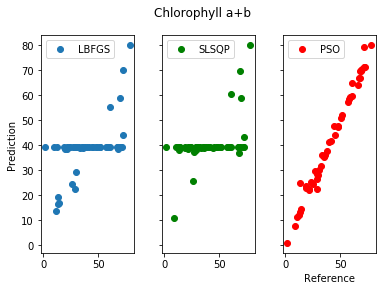

In [36]:
#plotting cab
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Chlorophyll a+b')
fig.subplots_adjust(wspace=.3)

#plt.subplot(3,1,1)
axs[0].plot(np_optim_traits[:,0],np_lbfgs[:,0],"o",label="LBFGS")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(np_optim_traits[:,0],np_slsqp[:,0],"o",color="green",label="SLSQP")
axs[1].legend(loc="upper left")
axs[2].plot(np_optim_traits[:,0],np_pso[:,0],"o",color="red",label="PSO")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")


Text(0.5, 0, 'Reference')

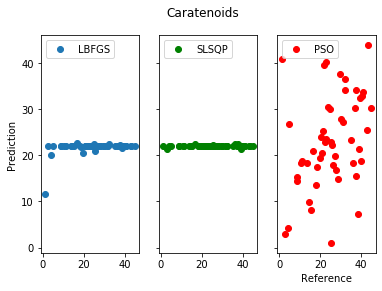

In [39]:
#plotting cab
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Caratenoids')
fig.subplots_adjust(wspace=.3)

#plt.subplot(3,1,1)
axs[0].plot(np_optim_traits[:,1],np_lbfgs[:,1],"o",label="LBFGS")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(np_optim_traits[:,1],np_slsqp[:,1],"o",color="green",label="SLSQP")
axs[1].legend(loc="upper left")
axs[2].plot(np_optim_traits[:,1],np_pso[:,1],"o",color="red",label="PSO")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")

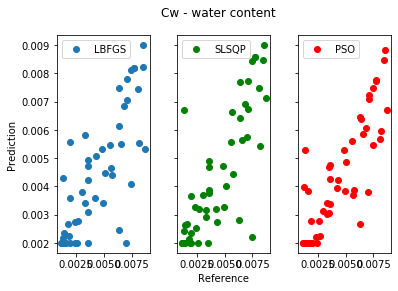

In [43]:
#plotting cab
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Cw - water content')
fig.subplots_adjust(wspace=.3)

#plt.subplot(3,1,1)
axs[0].plot(np_optim_traits[:,2],np_lbfgs[:,2],"o",label="LBFGS")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(np_optim_traits[:,2],np_slsqp[:,2],"o",color="green",label="SLSQP")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(np_optim_traits[:,2],np_pso[:,2],"o",color="red",label="PSO")
axs[2].legend(loc="upper left")

#axs[0].ylabel("ANN")

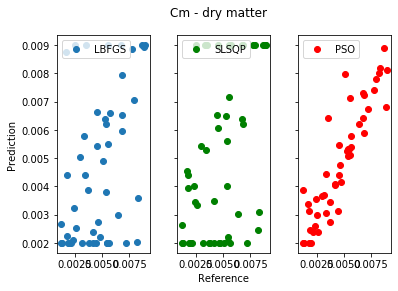

In [44]:

#plotting cab
fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Cm - dry matter')
fig.subplots_adjust(wspace=.3)

#plt.subplot(3,1,1)
axs[0].plot(np_optim_traits[:,3],np_lbfgs[:,3],"o",label="LBFGS")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(np_optim_traits[:,3],np_slsqp[:,3],"o",color="green",label="SLSQP")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(np_optim_traits[:,3],np_pso[:,3],"o",color="red",label="PSO")
axs[2].legend(loc="upper left")

#axs[0].ylabel("ANN")

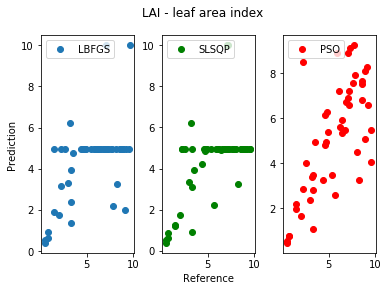

In [45]:
#plotting cab
fig, axs = plt.subplots(1,3,sharex=True)
fig.suptitle('LAI - leaf area index')
fig.subplots_adjust(wspace=.3)

#plt.subplot(3,1,1)
axs[0].plot(np_optim_traits[:,4],np_lbfgs[:,4],"o",label="LBFGS")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")
#axs[0].set(ylabel="Prediction")
axs[1].plot(np_optim_traits[:,4],np_slsqp[:,4],"o",color="green",label="SLSQP")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Reference")
axs[2].plot(np_optim_traits[:,4],np_pso[:,4],"o",color="red",label="PSO")
axs[2].legend(loc="upper left")
#axs[0].ylabel("ANN")

# There is no easy-2-use implementation of the shuffled stochastics evolution algorithm in python

I will use the R script for this part, the results just have to be adapted using the same input values as here in python. 



# This ends the optimization section for now



# Bayesian optimization 

Not as Mitra suggested yet but instead just as another approach to find the optimal solution for the minization problem.

[BayesianOptimization package](https://github.com/fmfn/BayesianOptimization)

notes to me:
I'm not convinced this is working properly.. it's too random.

- seems to me it is because the first points are generated randomly and after that it struggles. 

- check the order of the output cm, and cw seems inverted

- another weird detail is that the first samples are selected in the extremes of the bounding intervals

In [68]:
from bayes_opt import BayesianOptimization
import math
#running for a single trial:

#this package requires an adaptation to the cost function
#the value for the rho must be INSIDE and not part of the input

#this trick works:

#i chanve the rho_2_temp outside the function and then call the function
#this means i can put it into a loop
rho_s2_temp = np_optim_spectr[0,:]
def bayes_cost_s2(cab,car,cw,cm,lai):
  sim_canopy = custom_prosail(cab,car,cw,cm,lai)
  sim_canopy = Prosail2S2(filepath,sim_canopy)
  sim_canopy = sim_canopy[[1,2,3,4,5,6,8,11,12],]
  print(rho_s2_temp)
  samerror            = sptool.distance.SAM(rho_s2_temp,sim_canopy)

  #the other important difference is that this package maximizes instead of minimizing
  #we can just make the function output be 1/samerror - as samerror goes to 0, 1 can get infinitely bigger
  #if we want to limit the growth, we can just log the function above (maximizes in 1)

  return 1-samerror

#test_cab,test_car,test_cw,test_cm,test_lai=np_optim_traits[1,:]
#bayes_cost_s2(test_cab,test_car,test_cw,test_cm,test_lai)

#now we have to create the boundaries as a dictionary
pbounds= {'cab': (1,80), 'car': (1,45),
          'cw':(0.002,0.009),'cm':(0.002,0.009),
          'lai':(0.2,10)}

#testing for one iteration
optim_bayes = BayesianOptimization(
    f=bayes_cost_s2,
    pbounds=pbounds,
    random_state=0,
)

#basic usage
optim_bayes.maximize(
    init_points=300,
    n_iter=10,
)

print(optim_bayes.max)
print(np_optim_traits[0,:])



#more advanced usage
#from bayes_opt import UtilityFunction
#utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)
#next_point_to_probe = optim_bayes.suggest(utility)
#print("Next point to probe is:", next_point_to_probe)

#target = bayes_cost_s2(**next_point_to_probe)
#print("Found the target value to be:", target)








|   iter    |  target   |    cab    |    car    |    cm     |    cw     |    lai    |
-------------------------------------------------------------------------------------
[0.02191972 0.02959154 0.01987721 0.05795075 0.44963219 0.67811118
 0.68540725 0.38387153 0.18607373]
|  1        |  0.9221   |  44.36    |  32.47    |  0.006219 |  0.005814 |  4.352    |
[0.02191972 0.02959154 0.01987721 0.05795075 0.44963219 0.67811118
 0.68540725 0.38387153 0.18607373]
|  2        |  0.903    |  52.03    |  20.25    |  0.008242 |  0.008746 |  3.958    |
[0.02191972 0.02959154 0.01987721 0.05795075 0.44963219 0.67811118
 0.68540725 0.38387153 0.18607373]
|  3        |  0.7856   |  63.55    |  24.27    |  0.005976 |  0.008479 |  0.8962   |
[0.02191972 0.02959154 0.01987721 0.05795075 0.44963219 0.67811118
 0.68540725 0.38387153 0.18607373]
|  4        |  0.6545   |  7.883    |  1.89     |  0.007828 |  0.007447 |  8.726    |
[0.02191972 0.02959154 0.01987721 0.05795075 0.44963219 0.67811118
 0.685407